In [131]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
if not sess:
    sess = tf.InteractiveSession()

In [132]:
# ! wget www.math.uah.edu/stat/data/Fisher.csv

In [133]:
iris = pd.read_csv('Fisher.csv', 
                   skiprows=1, names=['target', 'petal_width', 'petal_length', 'sepal_width', 'sepal_length'])

iris.head()

,target,petal_width,petal_length,sepal_width,sepal_length
0,0,2,14,33,50
1,1,24,56,31,67
2,1,23,51,31,69
3,0,2,10,36,46
4,1,20,52,30,65


In [160]:
# number of input features + 1 constant term
feature_columns = iris.columns #[1:]
feature_columns = ['sepal_length', 'petal_width', 'petal_length', 'sepal_width']

n_samples = iris.shape[0]
C = iris.target.nunique()

In [189]:
poly = PolynomialFeatures(3, include_bias = True)
train_X = poly.fit_transform(iris.values[:,1:])
D = train_X.shape[1]
'''
train_X = np.hstack((
        np.ones(shape=(n_samples, 1)), 
        iris[feature_columns].values))
'''
train_Y = iris.target.values

train_X[:5,:10]
train_X.shape
# train_Y.shape

(150, 35)

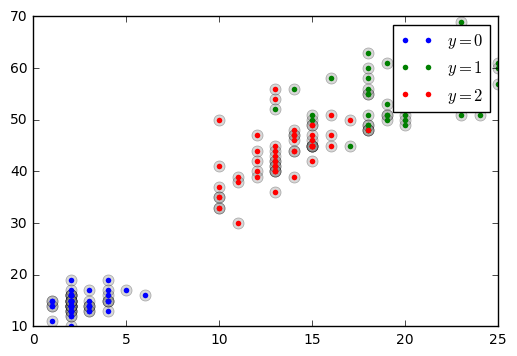

In [190]:
def plot_result(predicted_classes=None):

    if predicted_classes is None:
        plt.plot(train_X[:, 1], train_X[:, 2], 'o', ms=8, alpha=.3, color='grey');
    else:
        for c in range(C):
            mask = predicted_classes == c
            plt.plot(train_X[mask, 1], train_X[mask, 2], 'o', ms=8, alpha=.3, mec='none')
    plt.gca().set_prop_cycle(None)
    for c in range(C):
        mask = iris.target.values == c    
        plt.plot(train_X[mask, 1], train_X[mask, 2], 'o', ms=4, mec='none', label='$y = {}$'.format(c));
    plt.legend()
    
plot_result()

In [191]:
X = tf.placeholder("float", shape = [None, D])
Y = tf.placeholder("int32", shape = [None])

W = tf.Variable(tf.zeros_initializer(shape=(D, C)))
sess.run(W.initializer)

scores = tf.matmul(X, W)

probabilities = tf.nn.softmax(scores)

In [192]:
sess.run(probabilities, feed_dict={X: train_X[:5, :]})

array([[ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334,  0.33333334]], dtype=float32)

In [193]:
softmax_sample_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
 logits = scores,
 labels = Y
)

softmax_sample_losses

<tf.Tensor 'SparseSoftmaxCrossEntropyWithLogits_13/SparseSoftmaxCrossEntropyWithLogits:0' shape=(?,) dtype=float32>

In [194]:
softmax_loss = tf.reduce_mean(softmax_sample_losses)
print('batch average loss', sess.run(softmax_loss, feed_dict={X: train_X[:5, :], Y: train_Y[:5]}))

sess.run(softmax_sample_losses, feed_dict={X: train_X[:5, :], Y: train_Y[:5]})

batch average loss 1.09861


array([ 1.09861231,  1.09861231,  1.09861231,  1.09861231,  1.09861231], dtype=float32)

n_correct_samples / n_samples = 50 150


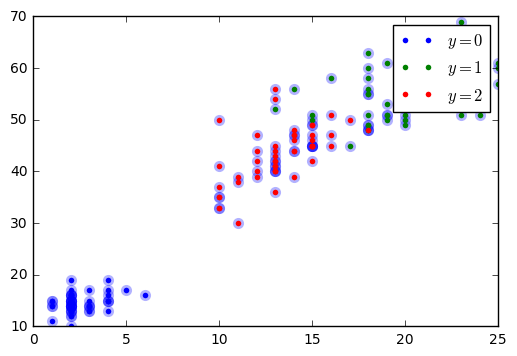

In [195]:
predicted_probs = sess.run(probabilities, feed_dict={X: train_X})
predicted_classes = predicted_probs.argmax(axis=1)
# classify everyone to the same class :/
n_correct_samples = np.sum(predicted_classes == train_Y)
print('n_correct_samples / n_samples =', n_correct_samples, n_samples)

plot_result(predicted_classes)

Copy the boilerplate code from the last session (https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_logistic_regression.ipynb, cell 43)
Replace the logistic_loss with the `batch_los`
Remove or adapt the fitted_ws[epoch, :] = fitted_w.ravel() line because we now have more weights
Use code above to print the number of correct predictions and plot the final result
decrease the learning rate to something slightly lower than .2

In [196]:
# make the gradient descent work 
# see here https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_multiclass_classification.ipynb
# get the graph right
# try to plug in more features

Epoch:    0, cost=1.0986, %correct 33.0
Epoch:   50, cost=2395695872.0000, %correct 76.0
Epoch:  100, cost=284852544.0000, %correct 88.0
Epoch:  150, cost=64102992.0000, %correct 91.0
Epoch:  200, cost=126500728.0000, %correct 92.0
Epoch:  250, cost=106182408.0000, %correct 94.0
Epoch:  300, cost=48523164.0000, %correct 95.0
Epoch:  350, cost=50042752.0000, %correct 94.0
Epoch:  400, cost=105182528.0000, %correct 96.0
Epoch:  450, cost=46264796.0000, %correct 96.0
Epoch:  500, cost=86341400.0000, %correct 96.0
Epoch:  550, cost=111446928.0000, %correct 93.0
Epoch:  600, cost=77674056.0000, %correct 95.0
Epoch:  650, cost=49930668.0000, %correct 93.0
Epoch:  700, cost=45316040.0000, %correct 97.0
Epoch:  750, cost=41340788.0000, %correct 97.0


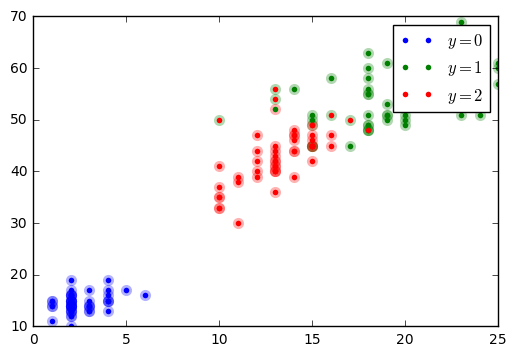

In [197]:
# Parameters
learning_rate = .1
n_epochs = 800
display_step = 50

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(softmax_loss)
init = tf.initialize_all_variables()

# fitted_ws = np.zeros((n_epochs, D))

for epoch in range(n_epochs):

    _, fitted_w, loss_value, predicted_probs = sess.run(
        fetches=[optimizer, W, softmax_loss, probabilities],
        feed_dict={X: train_X, Y: train_Y})
    # fitted_ws[epoch, :] = fitted_w.ravel()
    predicted_probs = sess.run(probabilities, feed_dict={X: train_X})
    predicted_classes = predicted_probs.argmax(axis=1)
    n_correct_samples = np.sum(predicted_classes == train_Y)
    percent_correct = round(n_correct_samples / len(predicted_classes) * 100)
    
    if (epoch) % display_step == 0:
        print("Epoch: {:4d}, cost={:.4f}, %correct {}".format(epoch, loss_value, percent_correct))

plot_result(predicted_classes)